# Module

In [119]:
import pandas as pd
import numpy as np
import joblib
from itertools import product
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from lightgbm.callback import early_stopping, log_evaluation
import optuna
from optuna.integration import LightGBMPruningCallback
from optuna.samplers import TPESampler
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances

# Data

In [2]:
data_path = "./data/"

sales_train = pd.read_csv(data_path + 'sales_train.csv')
items = pd.read_csv(data_path + 'items.csv')
item_categories = pd.read_csv(data_path + 'item_categories.csv')
shops = pd.read_csv(data_path + 'shops.csv')

test = pd.read_csv(data_path + 'test.csv')
sub = pd.read_csv(data_path + 'sample_submission.csv')

In [3]:
def downcast(df, verbose=True):
    start_memory = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col]%1==0).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        elif dtype_name.startswith('float'):
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_memory = df.memory_usage().sum() / 1024**2
    
    if verbose:
        print(f"Memory usage reduced from {start_memory:.2f} MB to {end_memory:.2f} MB")
        
    return df

In [4]:
data_files = [sales_train, items, shops, item_categories, test]
for file in data_files:
    file = downcast(file)

Memory usage reduced from 134.39 MB to 61.60 MB
Memory usage reduced from 0.51 MB to 0.23 MB
Memory usage reduced from 0.00 MB to 0.00 MB
Memory usage reduced from 0.00 MB to 0.00 MB
Memory usage reduced from 4.90 MB to 1.43 MB


In [5]:
train = []

for i in sales_train['date_block_num'].unique():
    all_shop = sales_train.loc[sales_train['date_block_num'] == i, 'shop_id'].unique()
    all_item = sales_train.loc[sales_train['date_block_num'] == i, 'item_id'].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))

# idx features        
idx_features = ['date_block_num', 'shop_id', 'item_id']
train = pd.DataFrame(np.vstack(train), columns=idx_features)

test['date_block_num'] = 34

In [6]:
train.head()

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564


In [7]:
test.head()

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34


# Feature Engineering

## Outliers

- 01_EDA.ipynb에서 살펴본 바에 따르면, 일반적인 IQR 방식 적용시 'item_price', 'item_cnt_day' 변수에서 전체 데이터의 약 10%가 이상치로 분류되었음
- 하지만 전체 데이터의 10%를 제거하는 것은 예측 모델링에 필요한 유의미한 정보까지 손실시킬 위험이 있음
- 따라서, 극단적인 이상치만을 제거하는 방법을 사용하였음
    - 시각화 과정을 통해 item_price : 50000 초과 / item_cnt_day : 1000 초과 를 이상치로 판단

In [8]:
(len(sales_train[sales_train['item_cnt_day'] > 1000]) / len(sales_train)) * 100

3.406169731481422e-05

In [9]:
(len(sales_train[sales_train['item_price'] > 50000]) / len(sales_train)) * 100

0.00010218509194444264

- 해당 데이터는 대량 거래 혹은 입력 오류 등의 가능성이 있고 그 비율이 전체 데이터 대비 무시할 수 있는 수준으로, 이를 제거하더라도 정보손실 없이 노이즈를 줄일 것으로 기대할 수 있음

In [10]:
print("Before : ",len(sales_train))
sales_train = sales_train[(sales_train['item_cnt_day'] > 0)&(sales_train['item_cnt_day'] < 1000)]
print("After item_cnt_day : ",len(sales_train))
sales_train = sales_train[(sales_train['item_price'] > 0)&(sales_train['item_price'] < 50000)]
print("After item_price : ",len(sales_train))

Before :  2935849
After item_cnt_day :  2928491
After item_price :  2928487


## Feature Generation

### shops

- 데이터셋 중 shop_name은 러시아어로 되어있는데, 상점명이 도시명으로 시작하는 것을 확인할 수 있음
- 또한, 일부 상점명은 표기시 일부 차이가 있지만 사실상 동일한 상점으로 판단됨 
    - 예) 
        - !Якутск Орджоникидзе, 56 фран <-> Якутск Орджоникидзе, 56
        - !Якутск ТЦ “Центральный” фран <-> Якутск ТЦ “Центральный”
        - Жуковский ул. Чкалова 39м? <-> Жуковский ул. Чкалова 39м²
        - РостовНаДону ТРК “Мегацентр Горизонт” <-> РостовНаДону ТРК “Мегацентр Горизонт” Островной

- 참고) https://www.kaggle.com/code/dlarionov/feature-engineering-xgboost

In [11]:
sales_train.loc[sales_train['shop_id']==0, 'shop_id'] = 57
sales_train.loc[sales_train['shop_id']==1, 'shop_id'] = 58
sales_train.loc[sales_train['shop_id']==10, 'shop_id'] = 11
sales_train.loc[sales_train['shop_id']==39, 'shop_id'] = 40

test.loc[test['shop_id']==0, 'shop_id'] = 57
test.loc[test['shop_id']==1, 'shop_id'] = 58
test.loc[test['shop_id']==10, 'shop_id'] = 11
test.loc[test['shop_id']==39, 'shop_id'] = 40

In [12]:
shops['city'] = shops['shop_name'].str.split(' ').str[0]
shops['city'].unique()

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

!Якутск 와 Якутск 은 동일한 도시를 나타냅니다. 

In [13]:
shops.loc[shops['city'] == '!Якутск', 'city'] = 'Якутск'

In [14]:
label_encoder = LabelEncoder()
shops['city'] = label_encoder.fit_transform(shops['city'])

In [15]:
shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,29
1,"!Якутск ТЦ ""Центральный"" фран",1,29
2,"Адыгея ТЦ ""Мега""",2,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,1
4,"Волжский ТЦ ""Волга Молл""",4,2


In [16]:
shops = shops.drop(columns=["shop_name"])
shops.head()

,shop_id,city
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


### items

In [17]:
items = items.drop(columns=["item_name"])
items.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


In [19]:
# 해당 아이템이 처음으로 판매된 월
items['first_sale_month'] = sales_train.groupby('item_id').agg({'date_block_num': 'min'})['date_block_num']
items.head()

,item_id,item_category_id,first_sale_month
0,0,40,20.0
1,1,76,15.0
2,2,40,19.0
3,3,40,18.0
4,4,40,20.0


In [20]:
items.isnull().sum()

item_id               0
item_category_id      0
first_sale_month    368
dtype: int64

In [21]:
items = items.fillna(34)

- 'first_sale_month'는 상품의 연식을 판단하기 위한 기준점으로, 0이라면 데이터가 시작된 시점인 2013년1월부터 판매된 상품이고 33이라면 2015년10월에 처음 판매된 신상품이라고 할 수 있음
- 결측치로 나타난 상품은 2015년10월까지 판매된 적 없는 상품으로, 테스트 데이터인 2015년 11월에 처음 출시되는 상품으로 판단할 수 있음

### item_category

In [22]:
item_categories

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


In [23]:
item_categories.loc[item_categories['item_category_name'].str.contains('-')]

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
75,Программы - Для дома и офиса,75
76,Программы - Для дома и офиса (Цифра),76
77,Программы - Обучающие,77
78,Программы - Обучающие (Цифра),78


In [24]:
item_categories.loc[~(item_categories['item_category_name'].str.contains('-'))]

,item_category_name,item_category_id
8,Билеты (Цифра),8
9,Доставка товара,9
32,"Карты оплаты (Кино, Музыка, Игры)",32
79,Служебные,79
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82
83,Элементы питания,83


- 'item_category_name'을 살펴보면 하이픈(-)을 기준으로 대분류-소분류로 구성되어 있는 걸로 보임
- 7개 카테고리는 하이픈을 포함하고 있지 않음. 하이픈을 포함하고 있지 않은 경우, 대분류와 소분류의 이름을 같게 처리

In [25]:
def split_categories(df):
    def split_func(name):
        if '-' in name:
            return name.split('-', 1)
        else:
            return [name, name]
    
    split_result = df['item_category_name'].apply(lambda x: split_func(x))
    df['type'] = split_result.apply(lambda x: x[0].strip())
    df['subtype'] = split_result.apply(lambda x: x[1].strip())
    return df

In [26]:
item_categories = split_categories(item_categories)
item_categories.head()

,item_category_name,item_category_id,type,subtype
0,PC - Гарнитуры/Наушники,0,PC,Гарнитуры/Наушники
1,Аксессуары - PS2,1,Аксессуары,PS2
2,Аксессуары - PS3,2,Аксессуары,PS3
3,Аксессуары - PS4,3,Аксессуары,PS4
4,Аксессуары - PSP,4,Аксессуары,PSP


In [27]:
item_categories['type'].value_counts()

type
Книги                                13
Подарки                              12
Игровые консоли                       8
Игры                                  8
Аксессуары                            7
Музыка                                6
Программы                             6
Кино                                  5
Карты оплаты                          4
Игры PC                               4
Служебные                             2
Чистые носители (штучные)             1
Чистые носители (шпиль)               1
PC                                    1
Карты оплаты (Кино, Музыка, Игры)     1
Игры MAC                              1
Игры Android                          1
Доставка товара                       1
Билеты (Цифра)                        1
Элементы питания                      1
Name: count, dtype: int64

- 대분류 건수가 5개 미만인 경우, 값을 'etc'로 통일

In [28]:
etc_types = item_categories['type'].value_counts()[item_categories['type'].value_counts()<5].index.tolist()
etc_types

['Карты оплаты',
 'Игры PC',
 'Служебные',
 'Чистые носители (штучные)',
 'Чистые носители (шпиль)',
 'PC',
 'Карты оплаты (Кино, Музыка, Игры)',
 'Игры MAC',
 'Игры Android',
 'Доставка товара',
 'Билеты (Цифра)',
 'Элементы питания']

In [29]:
item_categories.loc[item_categories['type'].isin(etc_types), 'type'] = 'etc'
item_categories['type'].value_counts()

type
etc                19
Книги              13
Подарки            12
Игровые консоли     8
Игры                8
Аксессуары          7
Музыка              6
Программы           6
Кино                5
Name: count, dtype: int64

In [30]:
item_categories.head()

,item_category_name,item_category_id,type,subtype
0,PC - Гарнитуры/Наушники,0,etc,Гарнитуры/Наушники
1,Аксессуары - PS2,1,Аксессуары,PS2
2,Аксессуары - PS3,2,Аксессуары,PS3
3,Аксессуары - PS4,3,Аксессуары,PS4
4,Аксессуары - PSP,4,Аксессуары,PSP


In [31]:
item_categories['type'] = LabelEncoder().fit_transform(item_categories['type'])
item_categories['subtype'] = LabelEncoder().fit_transform(item_categories['subtype'])

In [32]:
item_categories = item_categories.drop('item_category_name', axis=1)
item_categories.head()

,item_category_id,type,subtype
0,0,0,31
1,1,1,11
2,2,1,12
3,3,1,13
4,4,1,15


### derivative features

In [33]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1
1,03.01.2013,0,25,2552,899.00,1
3,06.01.2013,0,25,2554,1709.05,1
4,15.01.2013,0,25,2555,1099.00,1
5,10.01.2013,0,25,2564,349.00,1


In [34]:
group = sales_train.groupby(idx_features).agg(
    item_cnt_month = ('item_cnt_day', 'sum'),
    transaction_cnt = ('item_cnt_day', 'count'),
    avg_item_price = ('item_price', 'mean'),
).reset_index()

group.head()

,date_block_num,shop_id,item_id,item_cnt_month,transaction_cnt,avg_item_price
0,0,2,27,1,1,2499.0
1,0,2,33,1,1,499.0
2,0,2,317,1,1,299.0
3,0,2,438,1,1,299.0
4,0,2,471,2,2,399.0


In [35]:
train = train.merge(group, on=idx_features, how='left')
train.head()

,date_block_num,shop_id,item_id,item_cnt_month,transaction_cnt,avg_item_price
0,0,59,22154,1.0,1.0,999.0
1,0,59,2552,NaN,NaN,NaN
2,0,59,2554,NaN,NaN,NaN
3,0,59,2555,NaN,NaN,NaN
4,0,59,2564,NaN,NaN,NaN


### merge

In [36]:
all_data = pd.concat([train, test.drop('ID', axis=1)], ignore_index=True, keys=idx_features)
all_data.head()

/tmp/ipykernel_37851/4081425425.py:1: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  all_data = pd.concat([train, test.drop('ID', axis=1)], ignore_index=True, keys=idx_features)


,date_block_num,shop_id,item_id,item_cnt_month,transaction_cnt,avg_item_price
0,0,59,22154,1.0,1.0,999.0
1,0,59,2552,NaN,NaN,NaN
2,0,59,2554,NaN,NaN,NaN
3,0,59,2555,NaN,NaN,NaN
4,0,59,2564,NaN,NaN,NaN


In [37]:
all_data = all_data.fillna(0)

In [38]:
all_data = all_data.merge(shops, on='shop_id', how='left')
all_data = all_data.merge(items, on='item_id', how='left')
all_data = all_data.merge(item_categories, on='item_category_id', how='left')
all_data.head()

,date_block_num,shop_id,item_id,item_cnt_month,transaction_cnt,avg_item_price,city,item_category_id,first_sale_month,type,subtype
0,0,59,22154,1.0,1.0,999.0,30,37,0.0,4,1
1,0,59,2552,0.0,0.0,0.0,30,58,0.0,6,29
2,0,59,2554,0.0,0.0,0.0,30,58,0.0,6,29
3,0,59,2555,0.0,0.0,0.0,30,56,0.0,6,5
4,0,59,2564,0.0,0.0,0.0,30,59,0.0,6,42


In [39]:
all_data = downcast(all_data)

Memory usage reduced from 732.27 MB to 212.25 MB


In [40]:
del shops, items, item_categories, group

### time lag features

In [41]:
def add_mean_features(df, mean_features, groupby_features):
    if len(groupby_features) == 2:
        feature_name = f'avg_sales_month_by_{groupby_features[1]}'
    else:
        feature_name = f'avg_sales_month_by_{groupby_features[1]}_and_{groupby_features[2]}'
    
    agg_rules = {
        feature_name: ('item_cnt_month', 'mean')
    }
            
    group = df.groupby(groupby_features).agg(**agg_rules).reset_index()
    
    df = df.merge(group, on=groupby_features, how='left')
    df = downcast(df, verbose=False)
    mean_features.append(feature_name)
    
    del group
    
    return df, mean_features

In [42]:
item_mean_feature_list = []
all_data, item_mean_feature_list = add_mean_features(all_data, item_mean_feature_list, ['date_block_num', 'item_id'])
all_data, item_mean_feature_list = add_mean_features(all_data, item_mean_feature_list, ['date_block_num', 'item_id', 'city'])

shop_mean_feature_list = []
all_data, shop_mean_feature_list = add_mean_features(all_data, shop_mean_feature_list, ['date_block_num', 'shop_id', 'type'])

all_data.head()

,date_block_num,shop_id,item_id,item_cnt_month,transaction_cnt,avg_item_price,city,item_category_id,first_sale_month,type,subtype,avg_sales_month_by_item_id,avg_sales_month_by_item_id_and_city,avg_sales_month_by_shop_id_and_type
0,0,59,22154,1,1,999.0,30,37,0,4,1,0.400000,1.0,0.166518
1,0,59,2552,0,0,0.0,30,58,0,6,29,0.022222,0.0,0.084630
2,0,59,2554,0,0,0.0,30,58,0,6,29,0.022222,0.0,0.084630
3,0,59,2555,0,0,0.0,30,56,0,6,5,0.044444,0.0,0.084630
4,0,59,2564,0,0,0.0,30,59,0,6,42,0.088889,0.0,0.084630


In [43]:
print(item_mean_feature_list)
print(shop_mean_feature_list)

['avg_sales_month_by_item_id', 'avg_sales_month_by_item_id_and_city']
['avg_sales_month_by_shop_id_and_type']


In [44]:
def add_lag_features(df: pd.DataFrame, features_to_clip: list, key_features: list, lag_feature: str, lag_period: list, clip_flag: bool):
    for i in lag_period:
        df_temp = df[key_features + [lag_feature]].copy()
        df_temp['date_block_num'] += i
        
        lag_feature_name = f'{lag_feature}_lag_{i}'
        df_temp.columns = key_features + [lag_feature_name]
        
        df = df.merge(df_temp.drop_duplicates(), on=key_features, how='left')
        df[lag_feature_name] = df[lag_feature_name].fillna(0)
        
        if clip_flag:
            features_to_clip.append(lag_feature_name)
            
    df = downcast(df, False)
    del df_temp
    
    return df, features_to_clip

In [45]:
lag_features_to_clip = []

all_data, lag_features_to_clip = add_lag_features(all_data, features_to_clip=lag_features_to_clip, 
                                                  key_features=idx_features, lag_feature='item_cnt_month',
                                                  lag_period=[1,2,3,4,6,12], clip_flag=True)

all_data.head().T

,0,1,2,3,4
date_block_num,0.000000,0.000000,0.000000,0.000000,0.000000
shop_id,59.000000,59.000000,59.000000,59.000000,59.000000
item_id,22154.000000,2552.000000,2554.000000,2555.000000,2564.000000
item_cnt_month,1.000000,0.000000,0.000000,0.000000,0.000000
transaction_cnt,1.000000,0.000000,0.000000,0.000000,0.000000
avg_item_price,999.000000,0.000000,0.000000,0.000000,0.000000
city,30.000000,30.000000,30.000000,30.000000,30.000000
item_category_id,37.000000,58.000000,58.000000,56.000000,59.000000
first_sale_month,0.000000,0.000000,0.000000,0.000000,0.000000
type,4.000000,6.000000,6.000000,6.000000,6.000000


In [47]:
lag_features_to_clip

['item_cnt_month_lag_1',
 'item_cnt_month_lag_2',
 'item_cnt_month_lag_3',
 'item_cnt_month_lag_4',
 'item_cnt_month_lag_6',
 'item_cnt_month_lag_12']

In [48]:
all_data, lag_features_to_clip = add_lag_features(all_data, features_to_clip=lag_features_to_clip, 
                                                  key_features=idx_features, lag_feature='transaction_cnt',
                                                  lag_period=[1,2,3,4,6,12], clip_flag=False)

all_data, lag_features_to_clip = add_lag_features(all_data, features_to_clip=lag_features_to_clip, 
                                                  key_features=idx_features, lag_feature='avg_item_price',
                                                  lag_period=[1,2,3,4,6,12], clip_flag=False)

all_data.head()

,date_block_num,shop_id,item_id,item_cnt_month,transaction_cnt,avg_item_price,city,item_category_id,first_sale_month,type,...,transaction_cnt_lag_3,transaction_cnt_lag_4,transaction_cnt_lag_6,transaction_cnt_lag_12,avg_item_price_lag_1,avg_item_price_lag_2,avg_item_price_lag_3,avg_item_price_lag_4,avg_item_price_lag_6,avg_item_price_lag_12
0,0,59,22154,1,1,999.0,30,37,0,4,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,59,2552,0,0,0.0,30,58,0,6,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,59,2554,0,0,0.0,30,58,0,6,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,59,2555,0,0,0.0,30,56,0,6,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,59,2564,0,0,0.0,30,59,0,6,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
features_to_drop = []
features_to_drop.extend(['transaction_cnt', 'avg_item_price'])

- 'transaction_cnt', 'avg_item_price'는 예측시점 t에 알 수 없는 정보이므로 이후에 제거

In [50]:
all_data.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
       'transaction_cnt', 'avg_item_price', 'city', 'item_category_id',
       'first_sale_month', 'type', 'subtype', 'avg_sales_month_by_item_id',
       'avg_sales_month_by_item_id_and_city',
       'avg_sales_month_by_shop_id_and_type', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_4',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'transaction_cnt_lag_1', 'transaction_cnt_lag_2',
       'transaction_cnt_lag_3', 'transaction_cnt_lag_4',
       'transaction_cnt_lag_6', 'transaction_cnt_lag_12',
       'avg_item_price_lag_1', 'avg_item_price_lag_2', 'avg_item_price_lag_3',
       'avg_item_price_lag_4', 'avg_item_price_lag_6',
       'avg_item_price_lag_12'],
      dtype='object')

In [51]:
item_mean_feature_list

['avg_sales_month_by_item_id', 'avg_sales_month_by_item_id_and_city']

In [53]:
for feat in item_mean_feature_list:
    all_data, lag_feature_to_clip = add_lag_features(all_data, features_to_clip=lag_features_to_clip, 
                                                  key_features=idx_features, lag_feature=feat,
                                                  lag_period=[1,2,3,6,12], clip_flag=True)
    
all_data.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
       'transaction_cnt', 'avg_item_price', 'city', 'item_category_id',
       'first_sale_month', 'type', 'subtype', 'avg_sales_month_by_item_id',
       'avg_sales_month_by_item_id_and_city',
       'avg_sales_month_by_shop_id_and_type', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_4',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'transaction_cnt_lag_1', 'transaction_cnt_lag_2',
       'transaction_cnt_lag_3', 'transaction_cnt_lag_4',
       'transaction_cnt_lag_6', 'transaction_cnt_lag_12',
       'avg_item_price_lag_1', 'avg_item_price_lag_2', 'avg_item_price_lag_3',
       'avg_item_price_lag_4', 'avg_item_price_lag_6', 'avg_item_price_lag_12',
       'avg_sales_month_by_item_id_lag_1', 'avg_sales_month_by_item_id_lag_2',
       'avg_sales_month_by_item_id_lag_3', 'avg_sales_month_by_item_id_lag_6',
       'avg_sales_month_by_item_id_lag_12',
   

- 'avg_sales_month_by_item_id', 'avg_sales_month_by_item_id_and_city'는 타겟값(월별 판매량)의 정보를 포함하기 때문에 시차 피쳐를 생성 후 삭제

In [54]:
all_data = all_data.drop(columns=item_mean_feature_list)

In [55]:
all_data, lag_feature_to_clip = add_lag_features(all_data, features_to_clip=lag_features_to_clip, 
                                                key_features=idx_features, lag_feature=shop_mean_feature_list[0],
                                                lag_period=[1,2,3,6,12], clip_flag=True)
    
all_data = all_data.drop(columns=shop_mean_feature_list)

In [56]:
lag_feature_to_clip

['item_cnt_month_lag_1',
 'item_cnt_month_lag_2',
 'item_cnt_month_lag_3',
 'item_cnt_month_lag_4',
 'item_cnt_month_lag_6',
 'item_cnt_month_lag_12',
 'avg_sales_month_by_item_id_lag_1',
 'avg_sales_month_by_item_id_lag_2',
 'avg_sales_month_by_item_id_lag_3',
 'avg_sales_month_by_item_id_lag_6',
 'avg_sales_month_by_item_id_lag_12',
 'avg_sales_month_by_item_id_and_city_lag_1',
 'avg_sales_month_by_item_id_and_city_lag_2',
 'avg_sales_month_by_item_id_and_city_lag_3',
 'avg_sales_month_by_item_id_and_city_lag_6',
 'avg_sales_month_by_item_id_and_city_lag_12',
 'avg_sales_month_by_shop_id_and_type_lag_1',
 'avg_sales_month_by_shop_id_and_type_lag_2',
 'avg_sales_month_by_shop_id_and_type_lag_3',
 'avg_sales_month_by_shop_id_and_type_lag_6',
 'avg_sales_month_by_shop_id_and_type_lag_12']

In [57]:
sales_lag_cols = [col for col in all_data.columns if 'item_cnt_month_lag' in col]

all_data['avg_item_cnt_month_lag'] = all_data[sales_lag_cols].mean(axis=1)

In [58]:
all_data[lag_feature_to_clip + ['item_cnt_month', 'avg_item_cnt_month_lag']] = all_data[lag_feature_to_clip + ['item_cnt_month', 'avg_item_cnt_month_lag']].clip(0, 20)
all_data.head()

,date_block_num,shop_id,item_id,item_cnt_month,transaction_cnt,avg_item_price,city,item_category_id,first_sale_month,type,...,avg_sales_month_by_item_id_and_city_lag_2,avg_sales_month_by_item_id_and_city_lag_3,avg_sales_month_by_item_id_and_city_lag_6,avg_sales_month_by_item_id_and_city_lag_12,avg_sales_month_by_shop_id_and_type_lag_1,avg_sales_month_by_shop_id_and_type_lag_2,avg_sales_month_by_shop_id_and_type_lag_3,avg_sales_month_by_shop_id_and_type_lag_6,avg_sales_month_by_shop_id_and_type_lag_12,avg_item_cnt_month_lag
0,0,59,22154,1,1,999.0,30,37,0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,59,2552,0,0,0.0,30,58,0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,59,2554,0,0,0.0,30,58,0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,59,2555,0,0,0.0,30,56,0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,59,2564,0,0,0.0,30,59,0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### price trend and sales trend

In [59]:
def add_trend_feature(df: pd.DataFrame, base_col: str, lags: list):
    for i in lags:
        col_lag_curr = f'{base_col}_lag_{i}'      
        col_lag_prev = f'{base_col}_lag_{i+1}'    
        col_trend = f'delta_{base_col}_lag_{i}'   
        
        if col_lag_prev not in df.columns or col_lag_curr not in df.columns:
            print(f'[Skip] {col_lag_curr} 또는 {col_lag_prev} 컬럼이 없어 작업을 종료합니다.')
            continue
            
        df[col_trend] = (df[col_lag_curr] - df[col_lag_prev]) / df[col_lag_prev]
        
        df[col_trend] = df[col_trend].replace([np.inf, -np.inf], np.nan)
        df[col_trend] = df[col_trend].fillna(0)
        
    df = downcast(df)

    return df

In [60]:
all_data = add_trend_feature(all_data, base_col='avg_item_price', lags=[1,2,3])
all_data = add_trend_feature(all_data, base_col='item_cnt_month', lags=[1,2,3])

Memory usage reduced from 1889.03 MB to 1644.94 MB
Memory usage reduced from 1899.64 MB to 1772.29 MB


### new item

In [61]:
all_data['new_item'] = all_data['first_sale_month'] == all_data['date_block_num']

In [62]:
all_data['month_diff'] = all_data['date_block_num'] - all_data['first_sale_month']

In [70]:
features_to_drop.append('first_sale_month')
features_to_drop

['transaction_cnt', 'avg_item_price', 'first_sale_month']

### days & month

In [64]:
all_data['month'] = all_data['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
all_data['days'] = all_data['month'].map(days)

In [65]:
all_data.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
       'transaction_cnt', 'avg_item_price', 'city', 'item_category_id',
       'first_sale_month', 'type', 'subtype', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_4',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'transaction_cnt_lag_1', 'transaction_cnt_lag_2',
       'transaction_cnt_lag_3', 'transaction_cnt_lag_4',
       'transaction_cnt_lag_6', 'transaction_cnt_lag_12',
       'avg_item_price_lag_1', 'avg_item_price_lag_2', 'avg_item_price_lag_3',
       'avg_item_price_lag_4', 'avg_item_price_lag_6', 'avg_item_price_lag_12',
       'avg_sales_month_by_item_id_lag_1', 'avg_sales_month_by_item_id_lag_2',
       'avg_sales_month_by_item_id_lag_3', 'avg_sales_month_by_item_id_lag_6',
       'avg_sales_month_by_item_id_lag_12',
       'avg_sales_month_by_item_id_and_city_lag_1',
       'avg_sales_month_by_item_id_and_city_lag_2',
       'avg_sales_mon

### removing columns

In [71]:
features_to_drop

['transaction_cnt', 'avg_item_price', 'first_sale_month']

In [72]:
all_data = all_data.drop(columns=features_to_drop)
all_data.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city',
       'item_category_id', 'type', 'subtype', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_4',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'transaction_cnt_lag_1', 'transaction_cnt_lag_2',
       'transaction_cnt_lag_3', 'transaction_cnt_lag_4',
       'transaction_cnt_lag_6', 'transaction_cnt_lag_12',
       'avg_item_price_lag_1', 'avg_item_price_lag_2', 'avg_item_price_lag_3',
       'avg_item_price_lag_4', 'avg_item_price_lag_6', 'avg_item_price_lag_12',
       'avg_sales_month_by_item_id_lag_1', 'avg_sales_month_by_item_id_lag_2',
       'avg_sales_month_by_item_id_lag_3', 'avg_sales_month_by_item_id_lag_6',
       'avg_sales_month_by_item_id_lag_12',
       'avg_sales_month_by_item_id_and_city_lag_1',
       'avg_sales_month_by_item_id_and_city_lag_2',
       'avg_sales_month_by_item_id_and_city_lag_3',
       'avg_sales_month_by_item_i

In [73]:
all_data = downcast(all_data)

Memory usage reduced from 1782.91 MB to 1708.62 MB


# Model

In [74]:
x_train = all_data[all_data['date_block_num'] < 33]
x_train = x_train.drop(['item_cnt_month'], axis=1)

x_val = all_data[all_data['date_block_num'] == 33]
x_val = x_val.drop(['item_cnt_month'], axis=1)

x_test = all_data[all_data['date_block_num'] == 34]
x_test = x_test.drop(['item_cnt_month'], axis=1)

y_train = all_data[all_data['date_block_num'] < 33]['item_cnt_month']
y_val = all_data[all_data['date_block_num'] == 33]['item_cnt_month']

In [75]:
del all_data

In [81]:
x_train.head()

,date_block_num,shop_id,item_id,city,item_category_id,type,subtype,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,...,delta_avg_item_price_lag_1,delta_avg_item_price_lag_2,delta_avg_item_price_lag_3,delta_item_cnt_month_lag_1,delta_item_cnt_month_lag_2,delta_item_cnt_month_lag_3,new_item,month_diff,month,days
0,0,59,22154,30,37,4,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,31
1,0,59,2552,30,58,6,29,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,31
2,0,59,2554,30,58,6,29,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,31
3,0,59,2555,30,56,6,5,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,31
4,0,59,2564,30,59,6,42,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,31


In [84]:
cat_features = ['shop_id', 'item_category_id', 'city', 'type', 'subtype', 'month']

dtrain = lgb.Dataset(x_train, y_train, categorical_feature=cat_features)
dval = lgb.Dataset(x_val, y_val, categorical_feature=cat_features, reference=dtrain)

## optuna

In [ ]:
%%time

fixed_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'force_col_wise': True,
    'random_state': 2025,
    'verbosity': -1
}

def objective_lgbm(trial):
    params = {
        **fixed_params,
        'num_leaves': trial.suggest_int('num_leaves', 31, 511),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
    }
    
    pruning_callback = LightGBMPruningCallback(trial, 'rmse', valid_name='eval')
    
    lgb_model = lgb.train(
        params=params,
        train_set=dtrain,
        num_boost_round=1500,
        valid_sets=[dval],
        valid_names=['eval'],
        callbacks=[
            early_stopping(stopping_rounds=300, verbose=False),
            log_evaluation(period=0),
            pruning_callback
        ]
    )
    
    # trial.set_user_attr("best_iter", lgb_model.best_iteration)
    
    preds = lgb_model.predict(x_val, num_iteration=lgb_model.best_iteration)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse 


sampler = TPESampler(seed=2025)
study_lgbm = optuna.create_study(direction='minimize', sampler=sampler)
study_lgbm.optimize(objective_lgbm, n_trials=10)

print(f'Total Trials : {len(study_lgbm.trials)}')
print(f'Best Trial : {study_lgbm.best_trial.number}')
print(f'Best Score : {study_lgbm.best_value:.5f}')
print('Best Parameters :')
for key, value in study_lgbm.best_params.items():
    print(f'{key} : {value}')

[I 2025-12-02 05:06:01,592] A new study created in memory with name: no-name-5acb2cde-d10a-4972-ac26-9e8ca3b24700


[I 2025-12-02 05:13:49,471] Trial 0 finished with value: 0.8697561558975807 and parameters: {'num_leaves': 96, 'learning_rate': 0.059662768998574464, 'feature_fraction': 0.9663028199432513, 'bagging_fraction': 0.7227840820237976, 'bagging_freq': 4}. Best is trial 0 with value: 0.8697561558975807.
[I 2025-12-02 05:27:10,904] Trial 1 finished with value: 0.8610243776423974 and parameters: {'num_leaves': 154, 'learning_rate': 0.020641210885923914, 'feature_fraction': 0.7463084687531312, 'bagging_fraction': 0.9821192096250286, 'bagging_freq': 9}. Best is trial 1 with value: 0.8610243776423974.
[I 2025-12-02 05:35:14,575] Trial 2 finished with value: 0.8617570127559372 and parameters: {'num_leaves': 249, 'learning_rate': 0.040005174874880194, 'feature_fraction': 0.5208589864093756, 'bagging_fraction': 0.8847289359689058, 'bagging_freq': 1}. Best is trial 1 with value: 0.8610243776423974.
[I 2025-12-02 05:50:27,874] Trial 3 finished with value: 0.857048021574062 and parameters: {'num_leaves'

Total Trials : 10
Best Trial : 3
Best Score : 0.85705
Best Parameters :
num_leaves : 171
learning_rate : 0.01666589592166009
feature_fraction : 0.9565136957103231
bagging_fraction : 0.6500575023723183
bagging_freq : 3
CPU times: user 3h 35s, sys: 22 s, total: 3h 57s
Wall time: 49min 25s


- Best Score : 0.85705

In [111]:
joblib.dump(study_lgbm, data_path + 'lgbm_study_result.pkl')

['./data/lgbm_study_result.pkl']

/tmp/ipykernel_37851/1748665859.py:1: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_lgbm)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

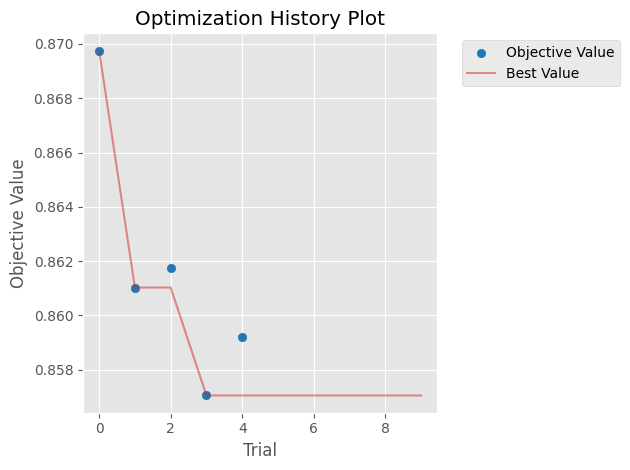

In [102]:
plot_optimization_history(study_lgbm)

/tmp/ipykernel_37851/3004270277.py:1: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study_lgbm)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

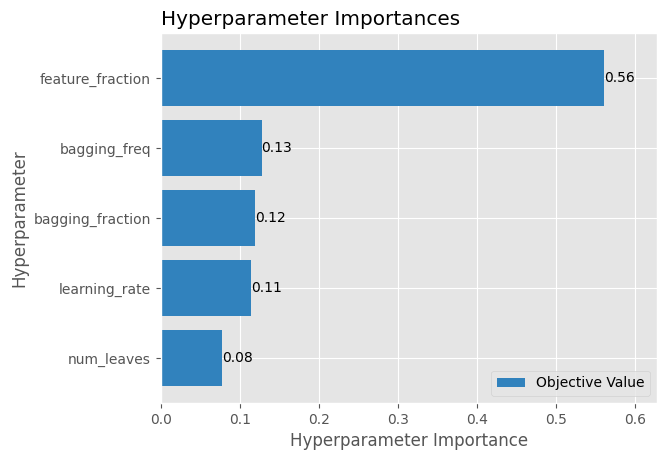

In [103]:
plot_param_importances(study_lgbm)

In [112]:
best_params = study_lgbm.best_params
best_params.update(fixed_params)

best_params

{'num_leaves': 171,
 'learning_rate': 0.01666589592166009,
 'feature_fraction': 0.9565136957103231,
 'bagging_fraction': 0.6500575023723183,
 'bagging_freq': 3,
 'objective': 'regression',
 'metric': 'rmse',
 'force_col_wise': True,
 'random_state': 2025,
 'verbosity': -1}

In [113]:
check_model = lgb.train(
    params=best_params,
    train_set=dtrain,
    num_boost_round=3000,        
    valid_sets=[dval],
    valid_names=['eval'],
    callbacks=[
        early_stopping(stopping_rounds=100),
        log_evaluation(period=100)
    ]
)

best_iter = check_model.best_iteration
best_iter

Training until validation scores don't improve for 100 rounds
[100]	eval's rmse: 0.885149
[200]	eval's rmse: 0.866297
[300]	eval's rmse: 0.862152
[400]	eval's rmse: 0.860776
[500]	eval's rmse: 0.859718
[600]	eval's rmse: 0.859272
[700]	eval's rmse: 0.859085
[800]	eval's rmse: 0.85905
[900]	eval's rmse: 0.857891
[1000]	eval's rmse: 0.85802
[1100]	eval's rmse: 0.85746
[1200]	eval's rmse: 0.857292
[1300]	eval's rmse: 0.857205
[1400]	eval's rmse: 0.857273
Early stopping, best iteration is:
[1329]	eval's rmse: 0.857064


1329

## final model

In [114]:
x_all = pd.concat([x_train, x_val])
y_all = pd.concat([y_train, y_val])

len(x_all) / len(x_train)

1.0223097774211625

In [115]:
dtrain_all = lgb.Dataset(x_all, y_all, categorical_feature=cat_features)
final_iter = int(best_iter * 1.1)

- 최적 하이퍼 파라미터를 사용해 전체 데이터로 학습
- 이때, 데이터가 늘어남에 따라 num_boost_round가 늘어나야 함

In [117]:
final_lgbm_model = lgb.train(
    params=best_params,
    train_set=dtrain_all,
    num_boost_round=final_iter,
    valid_sets=[dtrain_all],
    callbacks=[
        log_evaluation(period=100)
    ]
)

[100]	training's rmse: 0.879011
[200]	training's rmse: 0.832766
[300]	training's rmse: 0.814361
[400]	training's rmse: 0.803279
[500]	training's rmse: 0.794791
[600]	training's rmse: 0.788136
[700]	training's rmse: 0.781958
[800]	training's rmse: 0.776025
[900]	training's rmse: 0.771715
[1000]	training's rmse: 0.767463
[1100]	training's rmse: 0.762975
[1200]	training's rmse: 0.759796
[1300]	training's rmse: 0.75662
[1400]	training's rmse: 0.753641


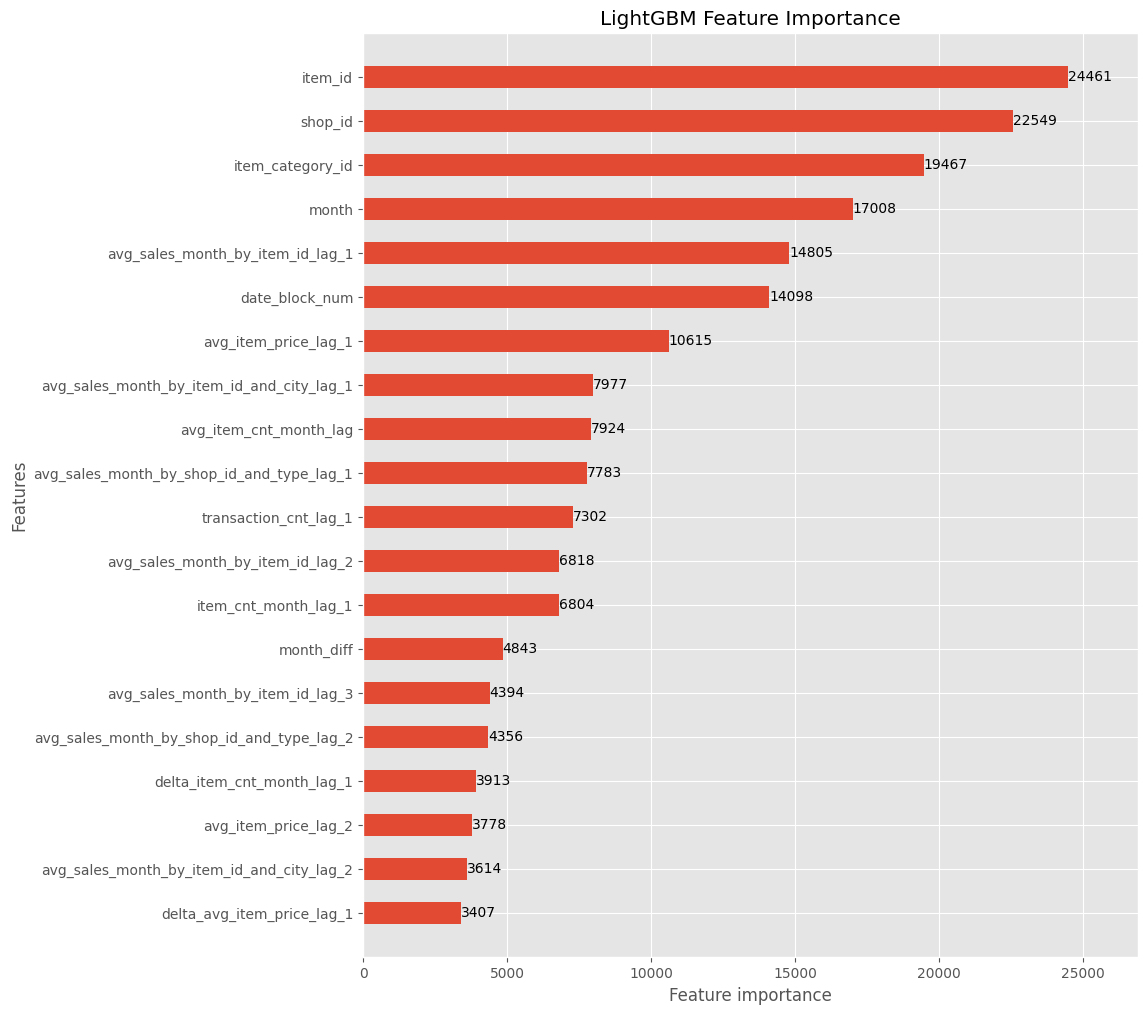

In [120]:
plt.figure(figsize=(10, 12)) 
lgb.plot_importance(final_lgbm_model, max_num_features=20, height=0.5, ax=plt.gca())
plt.title("LightGBM Feature Importance")
plt.show()

- id 변수 쏠림 현상 : 'item_id', 'shop_id', 'item_cateogry_id'의 중요도가 압도적으로 높아, 모델이 식별자를 암기하는 경향이 강함
- 시차 변수의 중요성 : 최근 시차 변수들의 중요도가 상위권에 포진

In [121]:
final_lgbm_model.save_model(data_path + 'final_lgbm_model.txt')

## prediction

In [122]:
sub.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [123]:
test.head()

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34


In [127]:
predictions = final_lgbm_model.predict(x_test, num_iteration=final_lgbm_model.best_iteration).clip(0, 20)
sub['item_cnt_month'] = predictions
sub.head()

,ID,item_cnt_month
0,0,0.425753
1,1,0.503317
2,2,0.822156
3,3,0.357933
4,4,2.139467


In [131]:
sub.to_csv(data_path + 'submission_lgbm.csv', index=False)

In [132]:
sub.tail()

,ID,item_cnt_month
214195,214195,0.096789
214196,214196,0.023257
214197,214197,0.034915
214198,214198,0.012129
214199,214199,0.035616


In [133]:
!chmod 600 /teamspace/studios/this_studio/.kaggle/kaggle.json
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f "./data/submission_lgbm.csv" -m "03_Emprovments_lgbm"

100%|██████████████████████████████████████| 5.21M/5.21M [00:00<00:00, 11.8MB/s]
Successfully submitted to Predict Future Sales

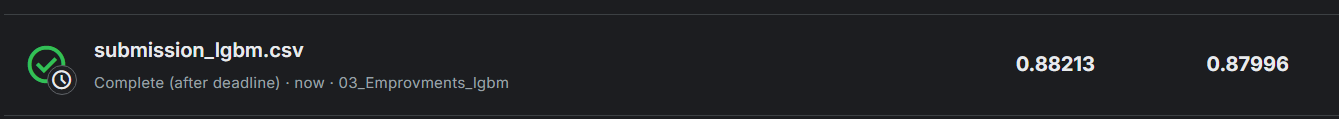

- Private Score 기준 1786 / 16993 (상위 10.5%)